In [77]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [78]:
# Set seed for reproducibility
np.random.seed(1111)
torch.manual_seed(1111)

In [79]:
# Define Lotka-Volterra dynamics
def lotka_volterra(t, u, p):
    α, β, γ, δ = p
    x, y = u
    dx = α * x - β * x * y
    dy = γ * x * y - δ * y
    return [dx, dy]

In [80]:
# True parameters
p_true = [1.3, 0.9, 0.8, 1.8]
tspan = (0, 5.0)
t_eval = np.arange(0, 5.01, 0.25)
u0 = 5.0 * np.random.rand(2)

In [81]:
sol = solve_ivp(lambda t, u: lotka_volterra(t, u, p_true), tspan, u0, t_eval=t_eval, atol=1e-12, rtol=1e-12)
X = sol.y
x_mean = np.mean(X, axis=1, keepdims=True)
noise_magnitude = 5e-3
Xn = X + noise_magnitude * x_mean * np.random.randn(*X.shape)

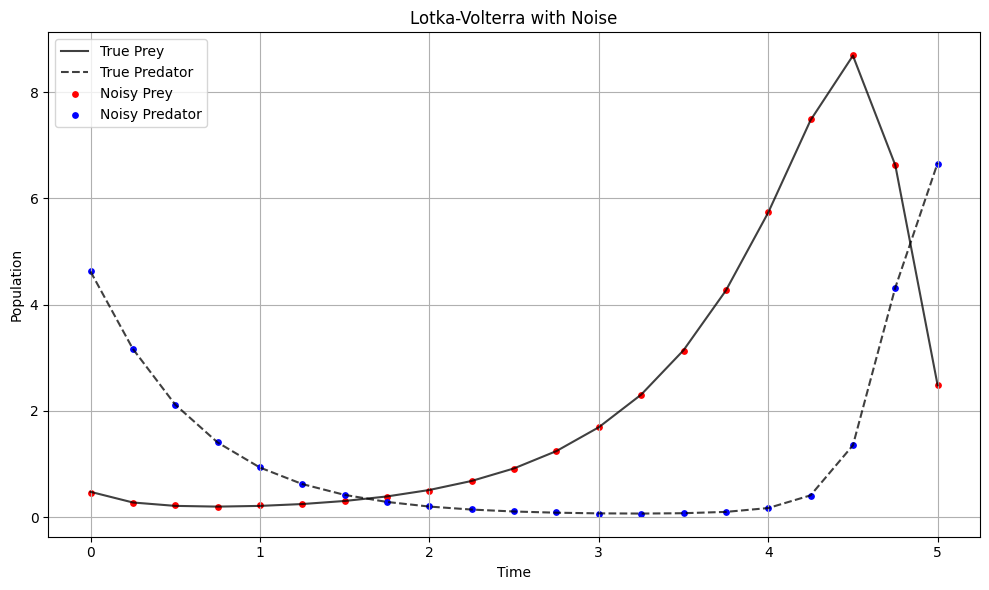

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(t, X[0], label="True Prey", color='black', alpha=0.75)
plt.plot(t, X[1], label="True Predator", color='black', linestyle='dashed', alpha=0.75)
plt.scatter(t, Xn[0], color='red', label="Noisy Prey", s=15)
plt.scatter(t, Xn[1], color='blue', label="Noisy Predator", s=15)
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Lotka-Volterra with Noise")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [83]:
# Convert to torch tensors
t_eval_tensor = torch.tensor(t_eval, dtype=torch.float32)
Xn_tensor = torch.tensor(Xn.T, dtype=torch.float32)

In [ ]:
# Define neural network model
class InteractionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 5),
            nn.GELU(),
            nn.Linear(5, 5),
            nn.GELU(),
            nn.Linear(5, 5),
            nn.GELU(),
            nn.Linear(5, 2)
        )

    def forward(self, x):
        return self.net(x)

model = InteractionNN()

In [ ]:
# Euler integration for differentiability
def euler_integrate(model, u0, t_eval, p):
    dt = t_eval[1] - t_eval[0]
    us = [u0]
    u = u0.clone()
    for _ in range(1, len(t_eval)):
        interaction = model(u.unsqueeze(0)).squeeze()
        dx = p[0] * u[0] + interaction[0]
        dy = -p[3] * u[1] + interaction[1]
        du = torch.stack([dx, dy])
        u = u + dt * du
        us.append(u)
    return torch.stack(us)

In [58]:
def compute_loss(model, Xn, t_eval, p):
    def rhs(t, u):
        x = tf.convert_to_tensor(u.reshape(1, -1), dtype=tf.float32)
        interaction = model(x)[0]
        dx = p[0] * u[0] + interaction[0]
        dy = -p[3] * u[1] + interaction[1]
        return [dx, dy]

    sol = solve_ivp(rhs, (t_eval[0], t_eval[-1]), Xn[:, 0], t_eval=t_eval, atol=1e-6, rtol=1e-6)
    X_pred = sol.y
    return tf.reduce_mean(tf.square(Xn - X_pred))



In [62]:
# Adam optimization
def train_adam(model, Xn, t_eval, p, epochs=5000, lr=1e-3):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    losses = []
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = compute_loss(model, Xn, t_eval, p)
        grads = tape.gradient(loss, model.trainable_variables)
        grads_and_vars = [(g, v) for g, v in zip(grads, model.trainable_variables) if g is not None]
        if grads_and_vars:
            optimizer.apply_gradients(grads_and_vars)
        losses.append(loss.numpy())
        if epoch % 50 == 0:
            print(f"Adam Epoch {epoch}: Loss = {loss.numpy()}")
    return losses


In [63]:
# L-BFGS optimization
def get_weights(model):
    return tf.concat([tf.reshape(w, [-1]) for w in model.trainable_weights], axis=0)

def set_weights(model, flat_weights):
    idx = 0
    for w in model.trainable_weights:
        shape = tf.shape(w)
        size = tf.reduce_prod(shape)
        new_val = tf.reshape(flat_weights[idx:idx + size], shape)
        w.assign(new_val)
        idx += size

def loss_and_grad(weights, model, Xn, t_eval, p):
    with tf.GradientTape() as tape:
        set_weights(model, weights)
        loss = compute_loss(model, Xn, t_eval, p)
    grads = tape.gradient(loss, model.trainable_variables)
    grad_flat = tf.concat([tf.reshape(g, [-1]) for g in grads], axis=0)
    return loss.numpy(), grad_flat.numpy()

def train_lbfgs(model, Xn, t_eval, p, maxiter=5000):
    init_weights = get_weights(model).numpy()
    result = minimize(
        fun=lambda w: loss_and_grad(w, model, Xn, t_eval, p),
        x0=init_weights,
        jac=True,
        method="L-BFGS-B",
        options={'maxiter': maxiter}
    )
    set_weights(model, result.x)
    return result.fun


In [65]:
losses_adam = train_adam(model, Xn, t_eval, p_true)
loss_lbfgs = train_lbfgs(model, Xn, t_eval, p_true)
print(f"Final loss after LBFGS: {loss_lbfgs}")

Adam Epoch 0: Loss = 707529.1150446467


KeyboardInterrupt: 